In [1]:
import math

### Define Model

In [2]:
class DBN:
    def __init__(self, n_v, layers, k=1, mean_field=True):
        
        if n_v is None or layers is None: raise ValueError("Incorrect inputs for layer 0.")
        
        n_hs = [n_v]        
        n_layer = 0
        training_done = True
        rbms = []
        for (n_h, model) in layers:
            n_layer += 1
            if model is None:
                if n_h <= 0: raise ValueError("Incorrect inputs for layer %d" % (n_layer))
                else: n_hs.append(n_h)

                rbm = RBM(n_hs[n_layer-1], n_h, k=k)
                training_done = False

            else:
                assert training_done
                
                rbm = RBM.load_model(model)
                assert rbm.n_v == n_hs[n_layer-1]                
                n_hs.append(rbm.n_h)

            rbms.append(rbm)

        self.n_hs = n_hs
        self.n_layer = n_layer
        self.training_done = training_done
        self.rbms = rbms
        self.mean_field = mean_field
        return
    
    def forward(self, X):
        assert self.training_done
        
        Hp = X
        for i in range(self.n_layer):
            Hp, Hs = self.rbms[i].forward(Hp)
        
        return Hp, Hs

    def backward(self, H):
        assert self.training_done

        Vp = H
        for i in reversed(range(self.n_layer)):
            Vp, Vs = self.rbms[i].backward(Vp)
        
        return Vp, Vs

    def train_1layer_1batch(self, V, layer):
        Hp = V
        for i in range(layer):
            Hp, Hs = self.rbms[i].forward(Hp)
        
        if self.mean_field or layer==0: 
            self.rbms[layer].contrastive_divergence(Hp, self.learning)
        else:
            for j in range(5):
                Vs = np.random.binomial(1, Hp, size=Hp.shape)
                self.rbms[layer].contrastive_divergence(Vs, self.learning)
                
        return

    def train_1layer(self, X, layer, epochs, batch_size=10, learning=0.01, save_file=None):
        assert not self.rbms[layer].training_done
        
        self.learning = learning
        n_x = X.shape[0]
        n_batch = n_x//batch_size
        startrate = learning
        for e in range(epochs):
            learning = startrate * math.pow(0.1, e//50) 
            for i in range(n_batch):
                s = i*batch_size
                V = X[s:s+batch_size]
                self.train_1layer_1batch(V, layer)

        self.rbms[layer].save_model(save_file+"-"+str(layer+1)+".epochs"+str(epochs))
        self.rbms[layer].training_done = True
        return
    
    # this is internal API for more complex network to use
    def train_model(self, X, epochs=1, batch_size=10, learning=0.01, save_file=None):
        
        for layer in range(self.n_layer):
            if self.rbms[layer].training_done: continue
            self.train_1layer(X, layer, epochs, batch_size, learning, save_file)
        
        return

    # this is the API for app to use
    def train(self, X, epochs=1, batch_size=10, learning=0.01, save_file=None):
        if self.training_done: return
        
        save_file += ".dbn.layer" + str(self.n_layer)
        self.train_model(X, epochs, batch_size, learning, save_file)
        
        self.training_done = True
        return
    
    def reconstruct(self, X):
        h_layer = self.n_layer - 1
        Hp = X
        for i in range(h_layer):
            Hp, Hs = self.rbms[i].forward(Hp)
        
        Vp, Vs = self.rbms[h_layer].reconstruct(Hp)

        for i in reversed(range(h_layer)):
            Hp, Hs = self.rbms[i].backward(Hp)

        return Hp, Hs
    
    def show_features(self, shapes, title, count=-1):
        
        #for i in range(self.n_layer):
        #    rbm = self.rbms[i]
        #    rbm.show_features(shapes[i], "MNIST learned features in DBN layer %d" % (i+1), count)

        lower_rbm = None
        for i in range(self.n_layer):
            rbm = self.rbms[i]
            if i!=0:
                W = np.dot(rbm.W, lower_rbm.W)
                rbm = RBM(W.shape[1], W.shape[0], W=W)
               
            rbm.show_features(shapes[0], title +" learned features in layer %d" % (i+1), count)
            lower_rbm = rbm

        return lower_rbm

In [3]:
class MNIST_DBN:
    
    def __init__(self, n_v, layers, data_path): 
        self.dbn = DBN(n_v, layers)
        
        self.train_input = MnistInput("train", data_path)
        self.test_input = MnistInput("test", data_path)
        return

    def train(self, train_size=-1, n_epoch=1, batch_size=10, learning=0.01):
        X = []
        n_x = 0
        for x, y in self.train_input.read(train_size):
            X.append(x)
            n_x += 1

        X = np.array(X).reshape(n_x, -1) > 30
        X = X*1 / 255
        
        self.dbn.train(X, n_epoch, batch_size, learning, save_file="mnist")
        return
    
    def test_reconstruct(self, n):
        X=[]; i=2*n
        for x, y in self.test_input.read(n):
            x *= np.random.binomial(1, i/(n*2), size=(28,28))
            x = x * 2*n/i
            x /= 255
            X.append(x)
            i -=1
        
        recon_X = []
        for i in range(n):
            Vp, Vs = self.dbn.reconstruct(X[i].reshape(1, -1))
            recon_X.append(Vp)

        return np.array(X).reshape(-1, 784), np.array(recon_X).reshape(-1, 784)

In [4]:
def mult(tuple):
    prod = 1
    for i in tuple:
        prod *= i
    return prod

### Training

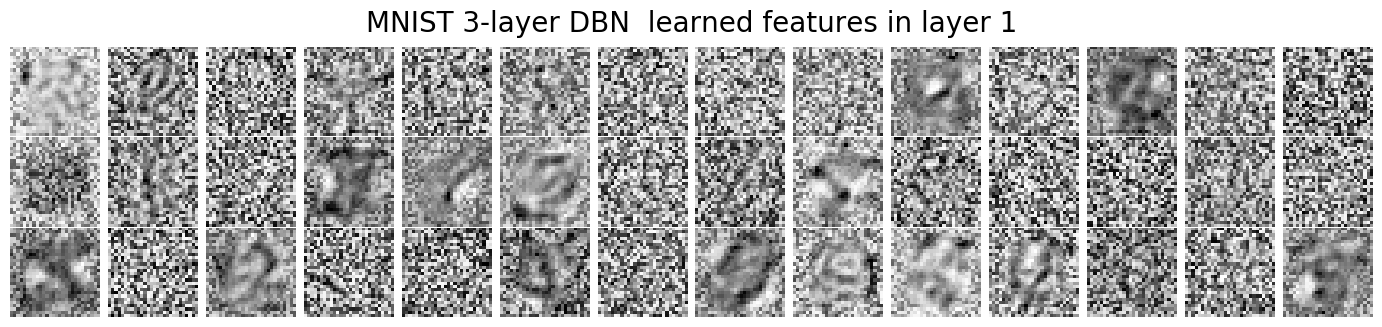

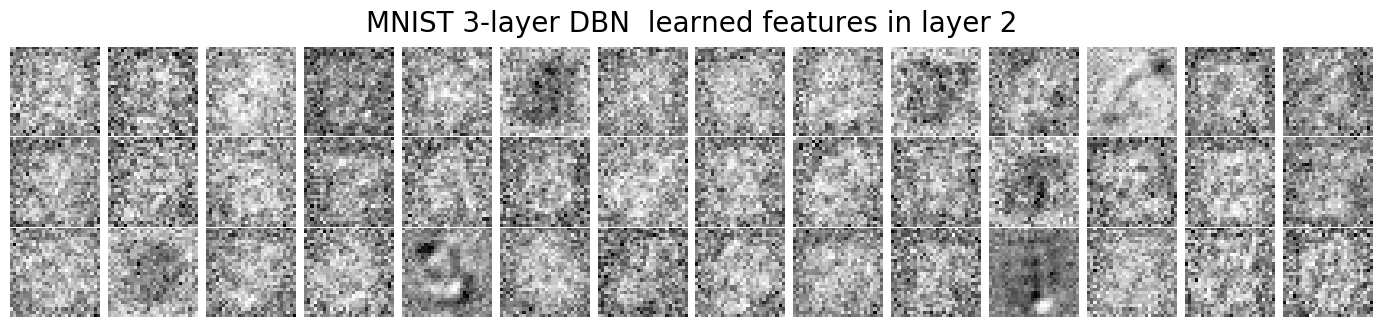

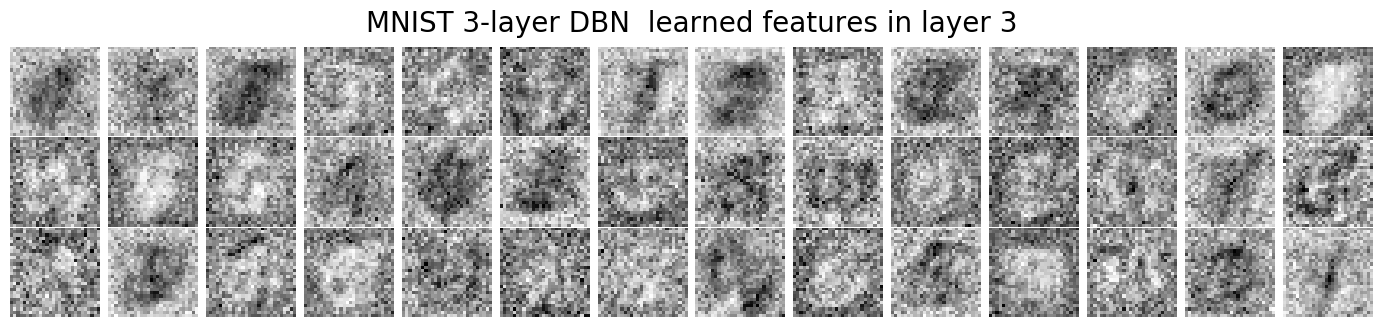

In [5]:
%run "RBM-backup.ipynb"

mnist_dbn = None
if __name__ == "__main__" and '__file__' not in globals():
    
    np.seterr(all='raise')
    plt.close('all')

    v = (28,28); h1 = (20,25); h2 = (20,25); h3 = (1000,1)
    
    #layers = [
    #    (mult(h1), None), # (dimension, "model_file") of hidden layer 1
    #    (mult(h2), None), # (dimension, "model_file") of hidden layer 2
    #    (mult(h3), None)  # (dimension, "model_file") of hidden layer 3
    #]

    layers = [
        (mult(h1), "trained_models/mnist_rbm.784x500.epochs100"), # hidden layer 1
        (mult(h2), "trained_models/mnist.dbn.layer3-2.epochs100.500x500"),
        (mult(h3), "trained_models/mnist.dbn.layer3-3.epochs100.500x1000")
    ]


    #set_trace()
    mnist_dbn = MNIST_DBN(mult(v), layers, "..")
    mnist_dbn.train(train_size=60000, n_epoch=200, batch_size=100,)

    feature_shapes = (v, h1, h2)
    mnist_dbn.dbn.show_features(feature_shapes,"MNIST %d-layer DBN " % (len(layers)),  14*3)
    x_sample, recon_x = mnist_dbn.test_reconstruct(100)

### Image Reconstruction

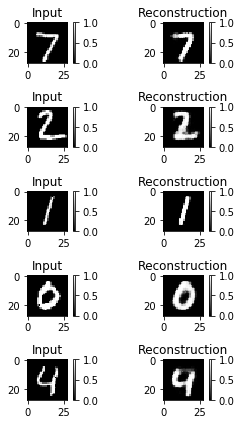

In [6]:
plt.figure(figsize=(4, 6))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(recon_x[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
    
plt.tight_layout()

In [7]:
def gen_mnist_image(X):
    return np.rollaxis(np.rollaxis(X[0:200].reshape(20, -1, 28, 28), 0, 2), 1, 3).reshape(-1, 20 * 28)

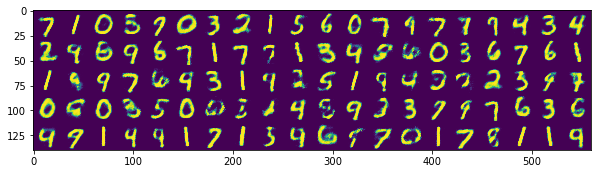

In [8]:
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(recon_x))

### Calculate Reconstruction Error

In [9]:
def calculate_recon_error(X, recon_X):
    """
    Compute the reconstruction error.
    """
    rec_loss = - np.sum(X * np.log(1e-8 + recon_X)
                           + (1 - X) * np.log(1e-8 + 1 - recon_X), 1)
    return np.mean(rec_loss)

In [10]:
calculate_recon_error(x_sample, recon_x)

133.11794513490418